In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
import matplotlib.pyplot as plt

In [3]:
from statsmodels.graphics.tsaplots import plot_acf

In [4]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [5]:
sp500 = pd.read_csv(os.path.join('new_data', 'GSPC_2015_2020.csv'), parse_dates = ['Date'], index_col = 'Date').sort_values(by = 'Date')
vix = pd.read_csv(os.path.join('new_data', 'VIX_2015_2020.csv'), parse_dates = ['Date'], index_col = 'Date').sort_values(by = 'Date')
t10_yield = pd.read_csv(os.path.join('new_data', 't10_yield_2015_2020.csv'), parse_dates = ['Date'], index_col = 'Date').sort_values(by  = 'Date')


In [6]:
def cal_return(df,
               col_name = 'Close'):
    ret = df[col_name][1:].values / df[col_name][:-1].values
    ret = np.append(1, ret)
    df['returns'] = ret
    return df

In [7]:
## Calculate returns
for df, col_name in zip((sp500, 
                         vix, 
                         t10_yield), 
                        ['Adj Close', 
                         'Adj Close', 
                         'Close']):
    df = cal_return(df, 
                    col_name)

In [8]:
## Common indexes in all datasets
idx = sp500.index.intersection(vix.index)
idx = idx.intersection(t10_yield.index)
sp500 = sp500.loc[idx]
vix = vix.loc[idx]
t10_yield = t10_yield.loc[idx]

In [9]:
## Filtering for years of which data is needed
start_year = '2016'
end_year = '2019'
sp500 = sp500.loc[start_year:end_year]
vix = vix.loc[start_year:end_year]
t10_yield = t10_yield.loc[start_year:end_year]

In [10]:
## Var model

In [11]:
sp500_ret = sp500['returns']
vix_ret = vix['returns']
t10_yield_ret = t10_yield['returns']

In [12]:
ret_data = pd.concat([sp500_ret, vix_ret, t10_yield_ret], axis = 1)
ret_data.columns = ['sp500', 'vix', 't10_yield']

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


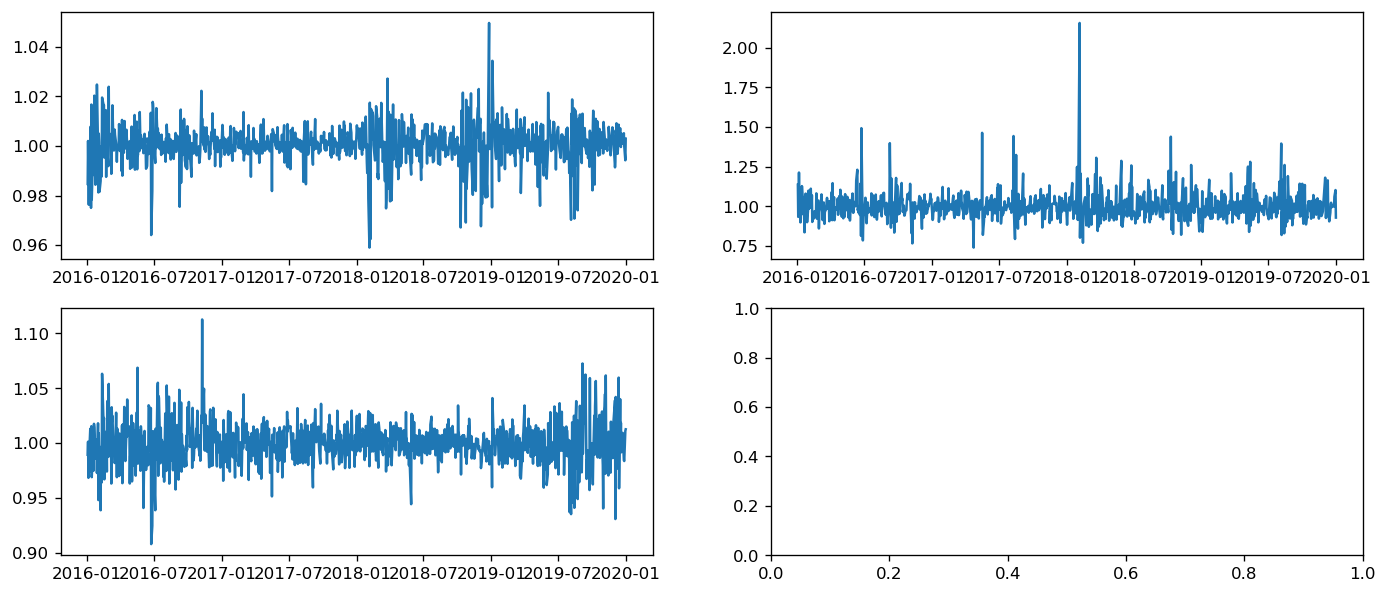

In [12]:
## Visualizing time series
fig, axes = plt.subplots(nrows = 2, ncols = 2, dpi = 120, figsize = (14,6))
axes[0][0].plot(sp500_ret)
axes[0][1].plot(vix_ret)
axes[1][0].plot(t10_yield_ret)
plt.show()

In [13]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(ret_data, variables = ret_data.columns) 

,sp500_x,vix_x,t10_yield_x
sp500_y,1.0000,0.0076,0.0007
vix_y,0.1339,1.0000,0.0011
t10_yield_y,0.0480,0.2868,1.0000


In [26]:
## vix and t10_yeild granger causes sp500
## t10_yield grangre causes vix
## sp500 granger causes t10_yield

In [21]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(ret_data)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
sp500  ::  349.87    > 24.2761   =>   True
vix    ::  151.88    > 12.3212   =>   True
t10_yield ::  0.03      > 4.1296    =>   False


In [22]:
## Dividing in test and train data
ret_train = ret_data.loc['2016':'2018']
ret_test = ret_data.loc['2019']

In [24]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [25]:
# ADF Test on each column
for name, column in ret_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "sp500" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -11.3209
 No. Lags Chosen       = 7
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "vix" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -11.9363
 No. Lags Chosen       = 7
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "t10_yield" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    

In [28]:
model = VAR(ret_train)
for i in range(1, 10):
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -23.386858061182725
BIC :  -23.31262655018749
FPE :  6.969742430492119e-11
HQIC:  -23.358247927716047 

Lag Order = 2
AIC :  -23.38512080022809
BIC :  -23.25507909742813
FPE :  6.981870646700098e-11
HQIC:  -23.334997295108952 

Lag Order = 3
AIC :  -23.415493188265287
BIC :  -23.22952379169944
FPE :  6.773024188637212e-11
HQIC:  -23.343808318422173 

Lag Order = 4
AIC :  -23.416324313772527
BIC :  -23.174309312771193
FPE :  6.767436935262375e-11
HQIC:  -23.323029915243303 

Lag Order = 5
AIC :  -23.405884153788065
BIC :  -23.10770522700635
FPE :  6.838524060287957e-11
HQIC:  -23.29093189088812 

Lag Order = 6
AIC :  -23.41032041425732
BIC :  -23.05585882769608
FPE :  6.808346854122977e-11
HQIC:  -23.273661778742582 

Lag Order = 7
AIC :  -23.41352246402875
BIC :  -23.002659069043503
FPE :  6.786708998146288e-11
HQIC:  -23.25510877425351 

Lag Order = 8
AIC :  -23.42593472523935
BIC :  -22.958549956536896
FPE :  6.703158158210279e-11
HQIC:  -23.245717125308914 

Lag

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [29]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,-23.43,-23.41*,6.677e-11,-23.42*
1,-23.42,-23.35,6.736e-11,-23.39
2,-23.42,-23.29,6.710e-11,-23.37
3,-23.45*,-23.27,6.512e-11*,-23.38
4,-23.44,-23.20,6.580e-11,-23.35
5,-23.43,-23.13,6.663e-11,-23.32
6,-23.44,-23.08,6.640e-11,-23.30
7,-23.43,-23.02,6.644e-11,-23.28
8,-23.43,-22.97,6.645e-11,-23.25
9,-23.43,-22.90,6.707e-11,-23.22


In [ ]:
## AIC values seems to remain constant throughout so no point of going further than lag 1

In [30]:
res = model.fit(1)
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 26, Aug, 2020
Time:                     11:15:08
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -23.3126
Nobs:                     746.000    HQIC:                  -23.3582
Log likelihood:           5559.71    FPE:                6.96974e-11
AIC:                     -23.3869    Det(Omega_mle):     6.85882e-11
--------------------------------------------------------------------
Results for equation sp500
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const                1.082604         0.060612           17.861           0.000
L1.sp500            -0.054659         0.057513           -0.950           0.342
L1.vix              -0.003338         0.005013           -0.666 

In [31]:
ret_forecast = res.forecast(ret_train.values[-1:], steps = 1)
for i in range(0, len(ret_test) - 1):
    ret_forecast = np.append(ret_forecast, res.forecast(ret_test.values[i:i+1], steps = 1), axis = 0)

In [32]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [33]:
def cal_mase(train,
             test,
             forecasted):
    mas = mean_absolute_error(forecasted, test)
    mas_naive = np.abs(train[1:] - train[:-1]).sum() / (len(train) - 1)
    return mas / mas_naive

In [34]:
cal_mase(ret_train['sp500'].values,
         ret_test['sp500'].values,
         ret_forecast[:, 0])

0.7014502078773336

In [35]:
def cal_hits(test, 
             forecasted):
    return ((test - 1) * (forecasted - 1) > 0).sum() / len(test)

In [36]:
cal_hits(ret_test['sp500'].values,
         ret_forecast[:,0])

0.5622489959839357

In [44]:
## Var exchange rates
eurgbp = cal_return(pd.read_csv(os.path.join('new_data', 'eurgbp_2015_2020.csv'), parse_dates = ['date'], index_col = 'date').sort_values(by = 'date'), 'close')
eurjpy = cal_return(pd.read_csv(os.path.join('new_data', 'eurjpy_2015_2020.csv'), parse_dates = ['date'], index_col = 'date').sort_values(by = 'date'), 'close')
eurusd = cal_return(pd.read_csv(os.path.join('new_data', 'eurusd_2015_2020.csv'), parse_dates = ['date'], index_col = 'date').sort_values(by = 'date'), 'close')
gbpjpy = cal_return(pd.read_csv(os.path.join('new_data', 'gbpjpy_2015_2020.csv'), parse_dates = ['date'], index_col = 'date').sort_values(by = 'date'), 'close')
gbpusd = cal_return(pd.read_csv(os.path.join('new_data', 'gbpusd_2015_2020.csv'), parse_dates = ['date'], index_col = 'date').sort_values(by = 'date'), 'close')

In [45]:
start_year = '2016'
end_year = '2019'
eurgbp = eurgbp.loc[start_year:end_year]
eurjpy = eurjpy.loc[start_year:end_year]
eurusd = eurusd.loc[start_year:end_year]
gbpjpy = gbpjpy.loc[start_year:end_year]
gbpusd = gbpusd.loc[start_year:end_year]

In [46]:
eurgbp_ret = eurgbp['returns']
eurjpy_ret = eurjpy['returns']
eurusd_ret = eurusd['returns']
gbpjpy_ret = gbpjpy['returns']
gbpusd_ret = gbpusd['returns']

In [47]:
ret_data_cur = pd.concat([eurgbp_ret, eurjpy_ret, eurusd_ret, gbpjpy_ret, gbpusd_ret], axis = 1)
ret_data_cur.columns = ['eurgbp', 'eurjpy', 'eurusd', 'gbpjpy', 'gbpusd']

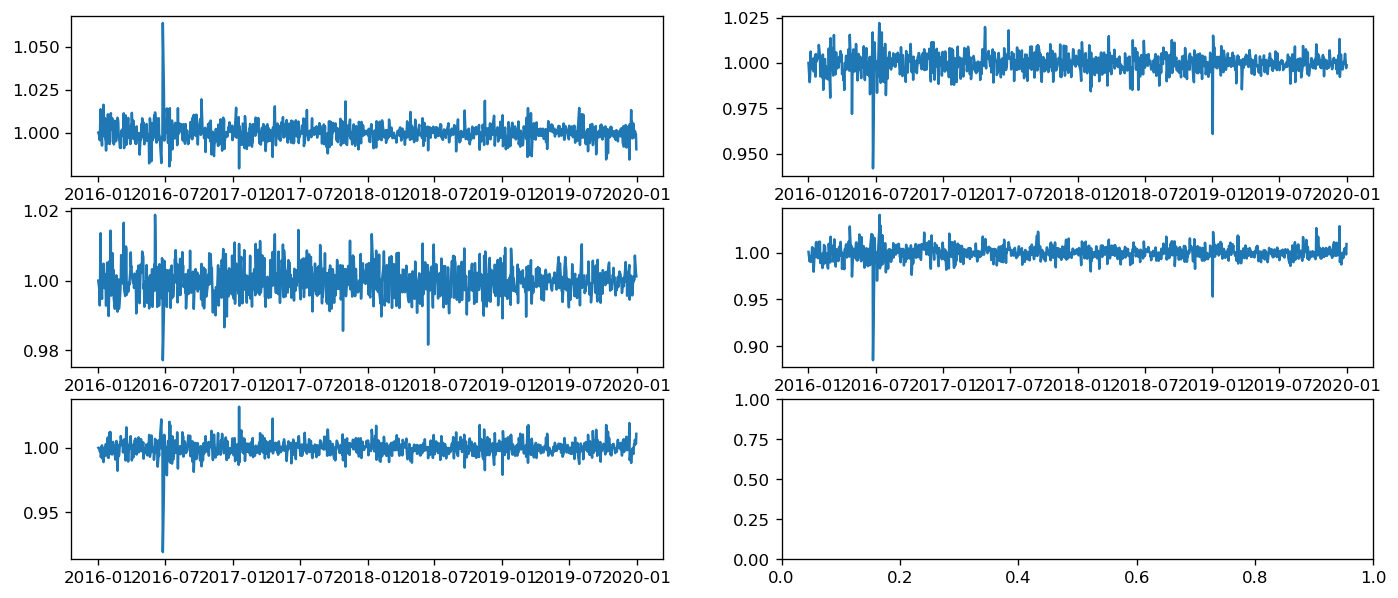

In [48]:
## Visualizing time series
fig, axes = plt.subplots(nrows = 3, ncols = 2, dpi = 120, figsize = (14,6))
axes[0][0].plot(eurgbp_ret)
axes[0][1].plot(eurjpy_ret)
axes[1][0].plot(eurusd_ret)
axes[1][1].plot(gbpjpy_ret)
axes[2][0].plot(gbpusd_ret)
plt.show()

In [49]:
grangers_causation_matrix(ret_data_cur, variables = ret_data_cur.columns) 

,eurgbp_x,eurjpy_x,eurusd_x,gbpjpy_x,gbpusd_x
eurgbp_y,1.0000,0.4037,0.0705,0.4274,0.0841
eurjpy_y,0.0101,1.0000,0.2152,0.0060,0.0107
eurusd_y,0.2433,0.0583,1.0000,0.3422,0.1992
gbpjpy_y,0.0221,0.0164,0.0959,1.0000,0.0423
gbpusd_y,0.0294,0.0725,0.0392,0.1765,1.0000


In [50]:
cointegration_test(ret_data_cur)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
eurgbp ::  819.69    > 60.0627   =>   True
eurjpy ::  515.74    > 40.1749   =>   True
eurusd ::  316.67    > 24.2761   =>   True
gbpjpy ::  146.58    > 12.3212   =>   True
gbpusd ::  0.0       > 4.1296    =>   False


In [52]:
## Dividing in test and train data
ret_train_cur = ret_data_cur.loc['2016':'2018']
ret_test_cur = ret_data_cur.loc['2019']

In [53]:
# ADF Test on each column
for name, column in ret_train_cur.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "eurgbp" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -26.6852
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "eurjpy" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -28.4889
 No. Lags Chosen       = 0
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "eurusd" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level   

In [54]:
model = VAR(ret_train_cur)
for i in range(1, 10):
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -64.70621756314195
BIC :  -64.52719418990867
FPE :  7.914936298799599e-29
HQIC:  -64.63736692245116 

Lag Order = 2
AIC :  -64.78345486538277
BIC :  -64.45491490950764
FPE :  7.326677813624127e-29
HQIC:  -64.65709399269646 

Lag Order = 3
AIC :  -64.7939877260338
BIC :  -64.31562972389047
FPE :  7.250053586229999e-29
HQIC:  -64.60999372383841 

Lag Order = 4
AIC :  -64.81154083795775
BIC :  -64.18306232248379
FPE :  7.124164394671893e-29
HQIC:  -64.56979038978915 

Lag Order = 5
AIC :  -64.83091729068495
BIC :  -64.05201478676244
FPE :  6.98786716052418e-29
HQIC:  -64.53128665917656 

Lag Order = 6
AIC :  -64.83224525920917
BIC :  -63.90261427901793
FPE :  6.979205959977322e-29
HQIC:  -64.47461028412832 

Lag Order = 7
AIC :  -64.82786416797104
BIC :  -63.74719920631479
FPE :  7.010703591248417e-29
HQIC:  -64.41210026424395 

Lag Order = 8
AIC :  -64.79315928882718
BIC :  -63.56115381843196
FPE :  7.25945460326302e-29
HQIC:  -64.31914144455209 

Lag Order = 9
AIC :

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)


In [55]:
model = VAR(ret_train_cur)
res = model.fit(1)
print(res.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 26, Aug, 2020
Time:                     11:23:52
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -64.5272
Nobs:                     781.000    HQIC:                  -64.6374
Log likelihood:           19756.8    FPE:                7.91494e-29
AIC:                     -64.7062    Det(Omega_mle):     7.61779e-29
--------------------------------------------------------------------
Results for equation eurgbp
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const            -0.558420         0.727052           -0.768           0.442
L1.eurgbp         1.565538         0.713407            2.194           0.028
L1.eurjpy        -0.683903         0.734869           -0.931           0.35

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)


In [56]:
ret_forecast_cur = res.forecast(ret_train_cur.values[-1:], steps = 1)
for i in range(0, len(ret_test_cur) - 1):
    ret_forecast_cur = np.append(ret_forecast_cur, res.forecast(ret_test_cur.values[i:i+1], steps = 1), axis = 0)

In [57]:
mase_cur = np.array([])
for index, column_name in enumerate(ret_train_cur.columns):
    mase_cur = np.append(mase_cur, cal_mase(ret_train_cur[column_name].values,
                                            ret_test_cur[column_name].values,
                                            ret_forecast_cur[:,index]))

In [58]:
ret_train_cur.columns, mase_cur

(Index(['eurgbp', 'eurjpy', 'eurusd', 'gbpjpy', 'gbpusd'], dtype='object'),
 array([0.60739286, 0.47848174, 0.45805014, 0.54641873, 0.61248905]))